# Dog Breed Classification with Sagemaker Pytorch

This notebook contains the steps to tune hyperparameters and train a Pytorch model for an image classification project. Once the best hyperparameters have been determined, the model will be trained in AWS Sagemaker and deployed as an endpoint for inference. The training process also generates a profiler report which includes the information of the model.

In [ ]:
# For instance, you will need the smdebug package
!pip install smdebug==1.0.16b20220418
!pip install -U bokeh
!pip install -U sagemaker

In [3]:
import sagemaker
import boto3
import os
from sagemaker.tuner import *

## Dataset
The project employs a dataset of dog images of 133 breeds. It's available via this link `https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip`. The zip file has three sub-folders: train, valid, and test, with each of them containing data for model training.

In [ ]:
# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

In [4]:
# Using the sagemaker SDK grab the current region, execution role, and bucket
import sagemaker
from sagemaker import get_execution_role

session = sagemaker.Session()
bucket = session.default_bucket()
region = session.boto_region_name
role = get_execution_role()

print("Default Bucket: {}".format(bucket))

print("AWS Region: {}".format(region))

print("RoleArn: {}".format(role))

Default Bucket: sagemaker-us-east-1-705959383387
AWS Region: us-east-1
RoleArn: arn:aws:iam::705959383387:role/service-role/AmazonSageMaker-ExecutionRole-20220825T005378


In [ ]:
# Upload data to S3
os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./dogImages s3://${DEFAULT_S3_BUCKET}/data/dogImages/

## Hyperparameter Tuning

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [5]:
# Declare your HP ranges, metrics etc.

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128, 256]),
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [48]:
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="hpo.py",
    role=role,
    py_version='py36',
    framework_version="1.6",
    instance_count=1,
    instance_type="ml.g4dn.xlarge"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [49]:
training_path= f"s3://{bucket}/data/dogImages/"
s3_output_dir = f"s3://{bucket}/output/"
s3_model_dir = f"s3://{bucket}/model/"

os.environ['SM_CHANNEL_TRAIN']=training_path
os.environ['SM_OUTPUT_DATA_DIR']=s3_output_dir
os.environ['SM_MODEL_DIR']=s3_model_dir

tuner.fit({'train': training_path}, wait=True) 

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


................................................................................................................................................................................................!


In [50]:
# Get the best estimators and the best HPs
best_estimator = tuner.best_estimator()

#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-08-28 21:08:21 Starting - Found matching resource for reuse
2022-08-28 21:08:21 Downloading - Downloading input data
2022-08-28 21:08:21 Training - Training image download completed. Training in progress.
2022-08-28 21:08:21 Uploading - Uploading generated training model
2022-08-28 21:08:21 Completed - Resource retained for reuse


{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"256"',
 'lr': '0.01390030725982051',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-08-28-20-52-24-240"',
 'sagemaker_program': '"hpo1.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-705959383387/pytorch-training-2022-08-28-20-52-24-240/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [6]:
# Set up debugging and profiling rules and hooks
from sagemaker.pytorch import PyTorch
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

rules = [
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, 
    framework_profile_params=FrameworkProfile(num_steps=10)
)

debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

[2022-08-29 00:18:26.742 pytorch-1-6-cpu-py36--ml-t3-medium-370ee60fbc7a856e8f67ac271515:67 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


In [7]:
# Create and fit an estimator

hyperparameters = {
    'lr': '0.01390030725982051',
    'batch-size': 256
}

estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    entry_point="train_model.py",
    framework_version="1.6",
    py_version="py36",
    profiler_config=profiler_config,
    hyperparameters=hyperparameters,
    debugger_hook_config=debugger_config,
    rules=rules,
)

training_path= f"s3://{bucket}/data/dogImages/"
s3_output_dir = f"s3://{bucket}/output/"
s3_model_dir = f"s3://{bucket}/model/"

os.environ['SM_CHANNEL_TRAIN']=training_path
os.environ['SM_OUTPUT_DATA_DIR']=s3_output_dir
os.environ['SM_MODEL_DIR']=s3_model_dir

estimator.fit({'train': training_path}, wait=True)

2022-08-29 00:18:41 Starting - Starting the training job...
2022-08-29 00:19:05 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
.........
2022-08-29 00:20:33 Downloading - Downloading input data............
2022-08-29 00:22:40 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-08-29 00:22:48,773 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-08-29 00:22:48,797 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-08-29 00:22:48,804 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-08-29 00:22:49,243 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framewor

In [8]:
# Plot a debugging output.
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2022-08-29 01:01:17.265 pytorch-1-6-cpu-py36--ml-t3-medium-370ee60fbc7a856e8f67ac271515:67 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-705959383387/pytorch-training-2022-08-29-00-18-40-802/debug-output


/opt/conda/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [9]:
trial.tensor_names()

[2022-08-29 01:01:24.342 pytorch-1-6-cpu-py36--ml-t3-medium-370ee60fbc7a856e8f67ac271515:67 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-08-29 01:01:25.368 pytorch-1-6-cpu-py36--ml-t3-medium-370ee60fbc7a856e8f67ac271515:67 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.bias',
 'gradient/ResNet_fc.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3.relu_input_1',
 'layer3.3.relu_input_2',
 'layer3.4.relu_input_0',
 'layer3.4.relu_input_1',
 '

In [10]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


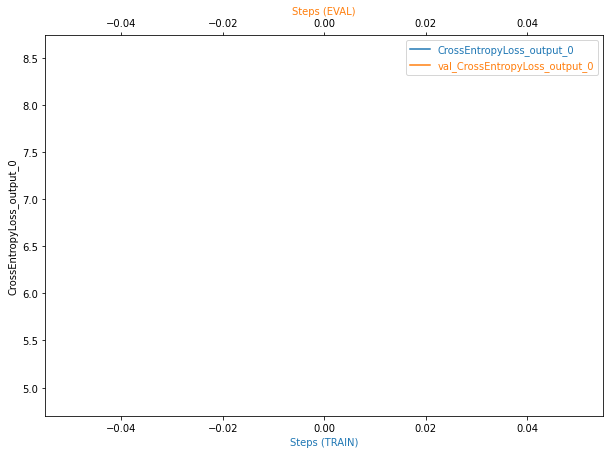

In [11]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [12]:
# Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

! aws s3 ls {rule_output_path} --recursive

2022-08-29 00:59:05     422031 pytorch-training-2022-08-29-00-18-40-802/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-08-29 00:59:04     278553 pytorch-training-2022-08-29-00-18-40-802/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-08-29 00:59:00        192 pytorch-training-2022-08-29-00-18-40-802/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-08-29 00:59:00     125298 pytorch-training-2022-08-29-00-18-40-802/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-08-29 00:59:00        126 pytorch-training-2022-08-29-00-18-40-802/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-08-29 00:59:00        329 pytorch-training-2022-08-29-00-18-40-802/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-08-29 00:59:00       4601 pytorch-training-2022-08-29-00-18-40-802/rule-output/ProfilerReport/profiler-output/profiler-re

In [13]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-705959383387/pytorch-training-2022-08-29-00-18-40-802/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-705959383387/pytorch-training-2022-08-29-00-18-40-802/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-us-east-1-705959383387/pytorch-training-2022-08-29-00-18-40-802/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-east-1-705959383387/pytorch-training-2022-08-29-00-18-40-802/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-705959383387/pytorch-training-2022-08-29-00-18-40-802/rule-

In [14]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]
profiler_report_name

'ProfilerReport'

In [15]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [16]:
# Deploy your model to an endpoint
predictor = estimator.deploy(
    initial_instance_count=1, 
    instance_type="ml.t2.medium"
)

endpoint = predictor.endpoint_name
print(endpoint)

----------!pytorch-training-2022-08-29-01-02-05-568


In [ ]:
!pip install torchvision

In [19]:
from PIL import Image

import torch.nn as nn
import torch
from torchvision import datasets
import numpy as np
import torchvision.transforms as transforms


def predict(img_path):
    image = Image.open(img_path)

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    img_tensor = transform(image).unsqueeze(0).to("cpu")
    img_tensor_pred = np.array(img_tensor).tobytes()

    response = predictor.predict(data=img_tensor_pred)
    pred = np.argmax(response, 1)+1
    plt.imshow(Image.open(image_path))
    plt.show()
    print(f"Expected: {int(image_path[17:20])}, Prediction: {pred[0]}")

In [ ]:
img_path = "./dogImages/test/003.Airedale_terrier/Airedale_terrier_00207.jpg"

predict(img_path)

In [21]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()